# Aula 5 - Demonstração de um Projeto de Dados

Vamos desenvolver um pequeno projeto com vocês para poder servir de *template para o projeto final*, com documentação de todos os passos e explicação de alguns pontos extras que podem ajudar na estrturação do raciocínio.

## **1. Pequeno Projeto de Demonstração - Manutenção Preditiva**

**Definição do Problema:** Com base em diversos valores de sensores, devemos desenvolver um modelo preditivo para determinar se a nossa máquina vai falhar a daqui 20 ciclos. Uma melhor descrição do problema pode ser encontrada [nesse link](https://github.com/IAugustoMZ/predictive_maintenance_case).

In [43]:
# pacotes
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, RFE
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

# ignorar warnings
warnings.filterwarnings('ignore')

# definição de constantes
DATASOURCE = './data/PM_train.txt'
RANDOM_SEED = 16
np.random.seed(RANDOM_SEED)

# lista de nomes de colunas (extraído do dicionário de dados)
real_col_names = [
    'asset_id',
    'runtime',
    'set1',
    'set2',
    'set3'
]

for i in range(1, 22):
    real_col_names.append(f'tag{i}')

### **1. Carrregar Dados e Análise Preliminar**

In [2]:
# carregando dados
data = pd.read_csv(DATASOURCE, header=None, sep=' ')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
# exploração inicial
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

In [4]:
# limpar colunas adicionais (100 % NaN)
data.drop([26, 27], axis=1, inplace=True)

In [5]:
# renomear as colunas com o dicionário de dados
data.columns = real_col_names
data.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
# verificação de dados nulos
data.isna().sum()

asset_id    0
runtime     0
set1        0
set2        0
set3        0
tag1        0
tag2        0
tag3        0
tag4        0
tag5        0
tag6        0
tag7        0
tag8        0
tag9        0
tag10       0
tag11       0
tag12       0
tag13       0
tag14       0
tag15       0
tag16       0
tag17       0
tag18       0
tag19       0
tag20       0
tag21       0
dtype: int64

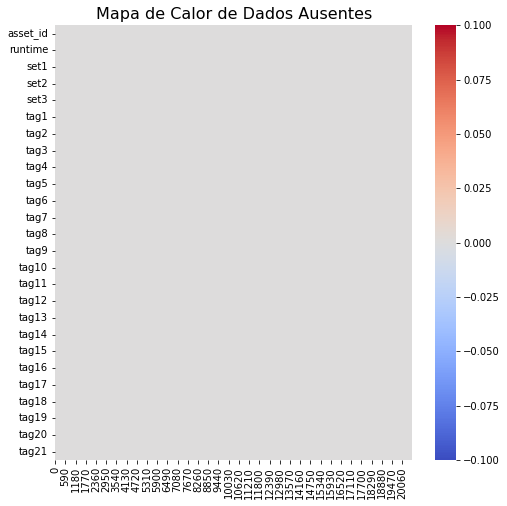

In [7]:
# mapa de calor de dados nulos
plt.figure(figsize=(8, 8))
sns.heatmap(data.isna().T, vmin=0, cmap='coolwarm')
plt.title('Mapa de Calor de Dados Ausentes', size=16)
plt.show()

### **2. Análise Exploratória de Dados**

In [8]:
# analisar qual é o máximo de ciclos para cada máquina
cycles_per_asset = pd.DataFrame(
    data.groupby(['asset_id'])['runtime'].max().values,
    columns=['ciclo_maximo'],
    index=data.groupby(['asset_id'])['runtime'].max().index
)

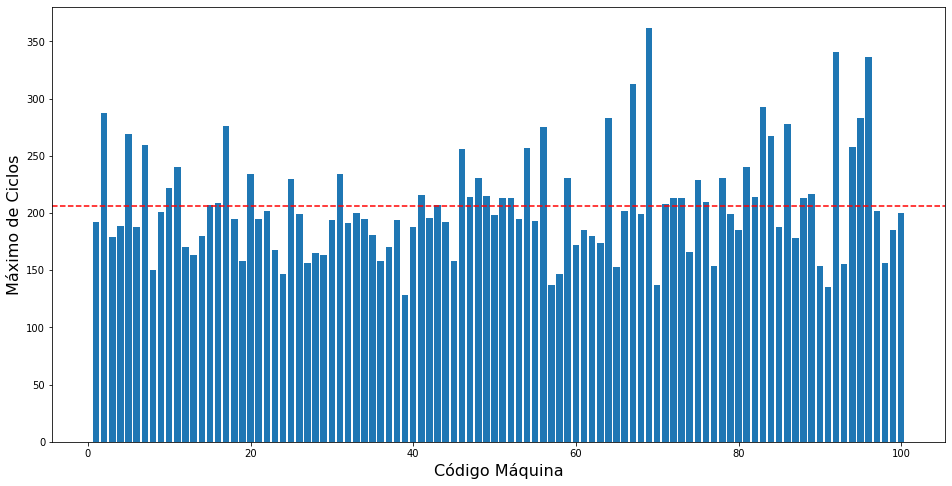

In [9]:
# visualizando ciclos máximos
plt.figure(figsize=(16, 8))
plt.bar(x=cycles_per_asset.index, height=cycles_per_asset.ciclo_maximo)
plt.axhline(y=np.mean(cycles_per_asset.ciclo_maximo.values), ls='--', color='red')
plt.xlabel('Código Máquina', size=16)
plt.ylabel('Máximo de Ciclos', size=16)
plt.show()

#### **2.1. Feature Engineering para criar classe de falha**

In [10]:
# função para realizar o feature engineeering da classe de falha
def create_failure_class(row,
                         grouped_data: pd.DataFrame) -> int:
    """
    cria a classe de falha
    1 - a máquina vai falhar em ciclo atual + 20 ciclos
    0 - a máquina não vai falhar em ciclo atual + 20 ciclos

    parâmtros:
        row: linha do dataframe
        grouped_data: dados agrupados por id
    retorna:
        classe de falha
    """

    # informação de negócio
    MAXIMO_CICLOS = 20

    # extrair o valor do ciclo histórico máximo pelo id
    max_cycle = grouped_data.loc[
        row['asset_id'],
        'ciclo_maximo'
    ]

    # aplica a regra de negócios de falha
    if row['runtime'] + MAXIMO_CICLOS > max_cycle:
        return 1
    else:
        return 0

In [11]:
# criação de classes de falhas
data['failure'] = data[['asset_id', 'runtime']].apply(
    create_failure_class,
    grouped_data=cycles_per_asset,
    axis=1
)
data.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,failure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0


In [12]:
# eliminando a coluna de id (queremos generalizar a predição para qualquer máquina,
# olhando apenas os valores dos sensores)
data.drop(['asset_id'], axis=1, inplace=True)

In [13]:
# checando estatísticas descritivas
data.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
set1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
set2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
set3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
tag1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
tag2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
tag3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
tag4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
tag5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
tag6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100


In [14]:
data.shape

(20631, 26)

Aparentemente, algumas variáveis possuem variância zero. Vamos verificar isso nos histogramas.

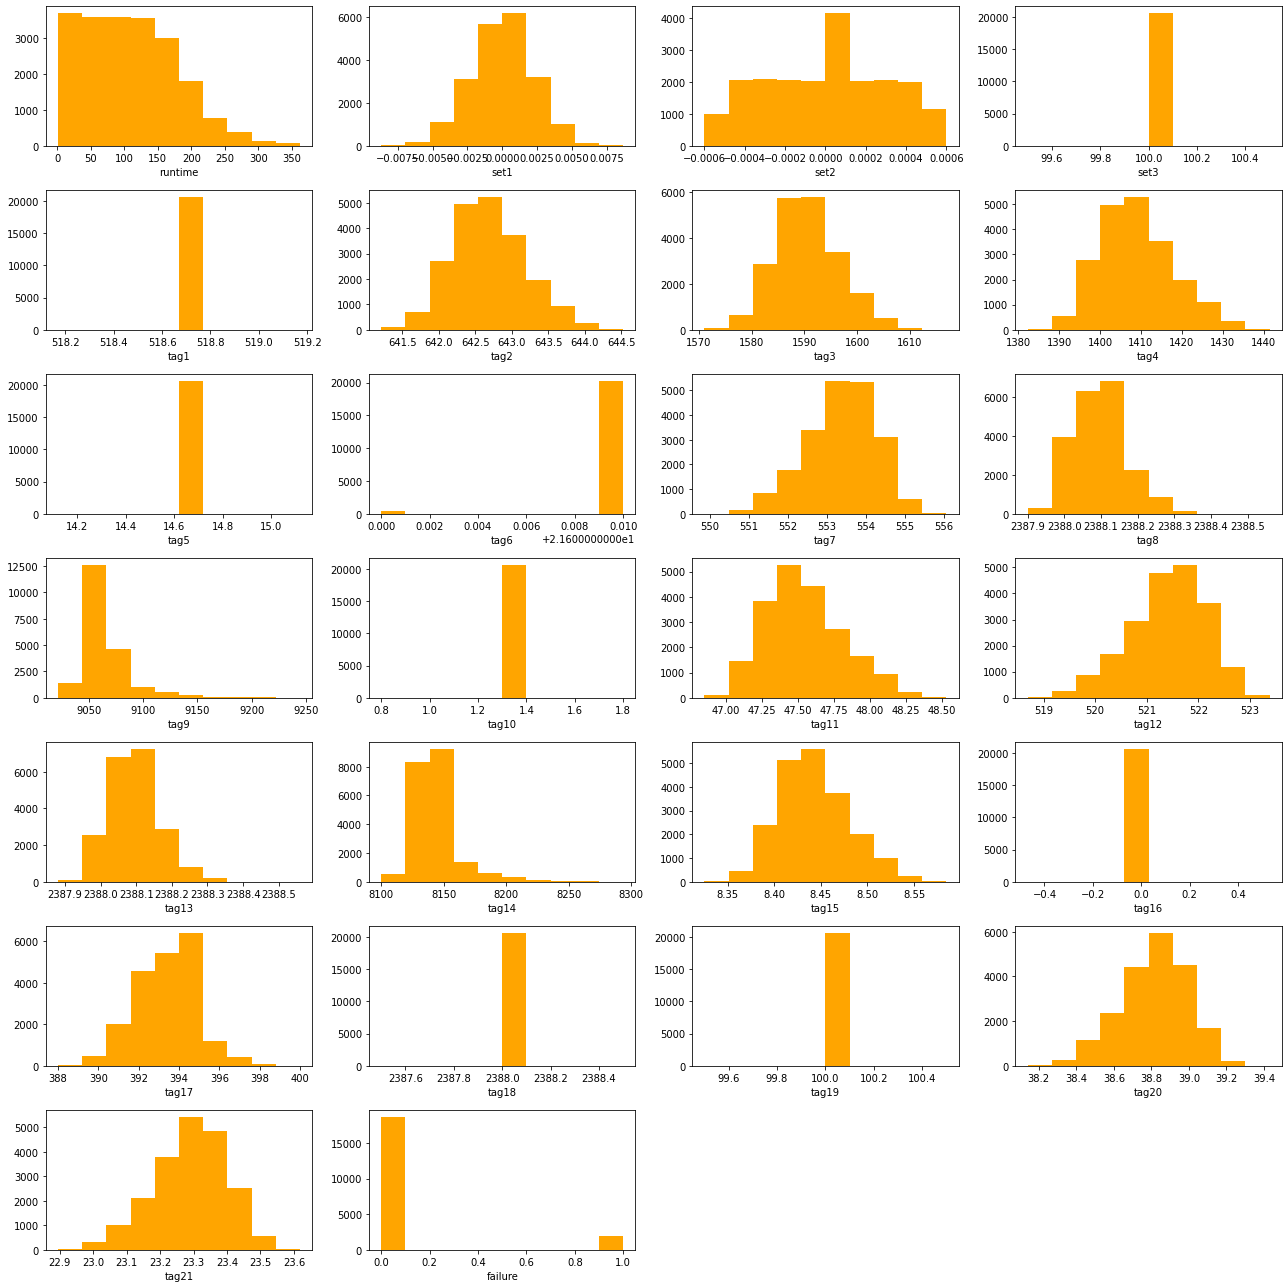

In [15]:
# construindo histogramas
fig = plt.figure(figsize=(18, 18))

for i in range(1, 27):

    ax = fig.add_subplot(7, 4, i)
    ax.hist(data.iloc[:, i-1], color='orange')
    ax.set_xlabel(data.columns[i-1])

plt.tight_layout()
plt.show()

No caso desse conjunto de dados, a maior parte dos sensores apresenta uma distribuição bem simétrica. Algumas features de fato possuem variância nula ou muito pequena. São elas: `set3`, `tag1`, `tag5`, `tag6`, `tag10`, `tag16`, `tag18` and `tag19`.

Para os atributos que não são tão simétricos, vamos usar o `QuantileTransform` na modelagem. Para o escalonamento, podemos usar o `RobustScaler`.

No momento de construir o pipeline de modelagem, vamos usar o objeto `VarianceThreshold` para selecionar os atributos com variância não nula, apenas.

In [16]:
# checando as linhas duplicadas
data.duplicated().sum()

0

In [17]:
# checando colunas duplicadas

# listar combinações das colunas em pares
comb = list(itertools.combinations(data.columns, 2))

# iterar pelas combinações de coluna e comparar os pares
dup_cols = []
for col1, col2 in comb:
    if ((col1 not in dup_cols) & (col2 not in dup_cols)):
        if data[col1].equals(data[col2]):   # aqui ocorre a comparação
            dup_cols.append(col1)

print(f'Quantidade de Colunas Duplicadas: {len(dup_cols)}')

Quantidade de Colunas Duplicadas: 1


In [18]:
# eliminar colunas
data.drop(dup_cols, axis=1, inplace=True)

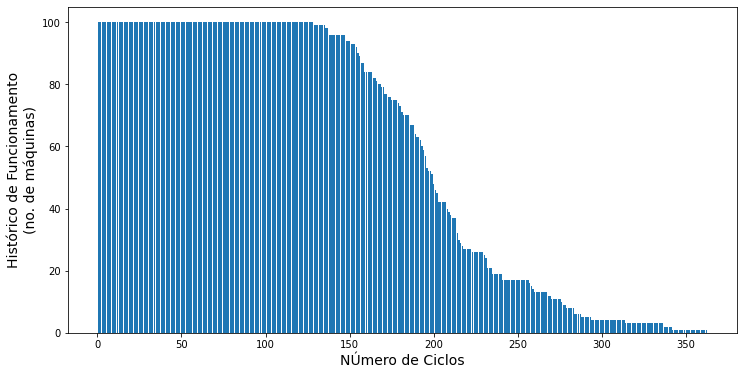

In [20]:
# análise de quantas máquinas duraram n ciclos?
plt.figure(figsize=(12, 6))
plt.bar(data.runtime.value_counts().index, data.runtime.value_counts().values)
plt.xlabel('Número de Ciclos', size=14)
plt.ylabel('Histórico de Funcionamento\n(no. de máquinas)', size=14)
plt.show()

A análise acima mostra que a coluna `runtime` pode ser um indicativo interessante da probabilidade de falha da máquina nos próximos ciclos, principalmente se o ciclo atual da máquina superar 130 ciclos.

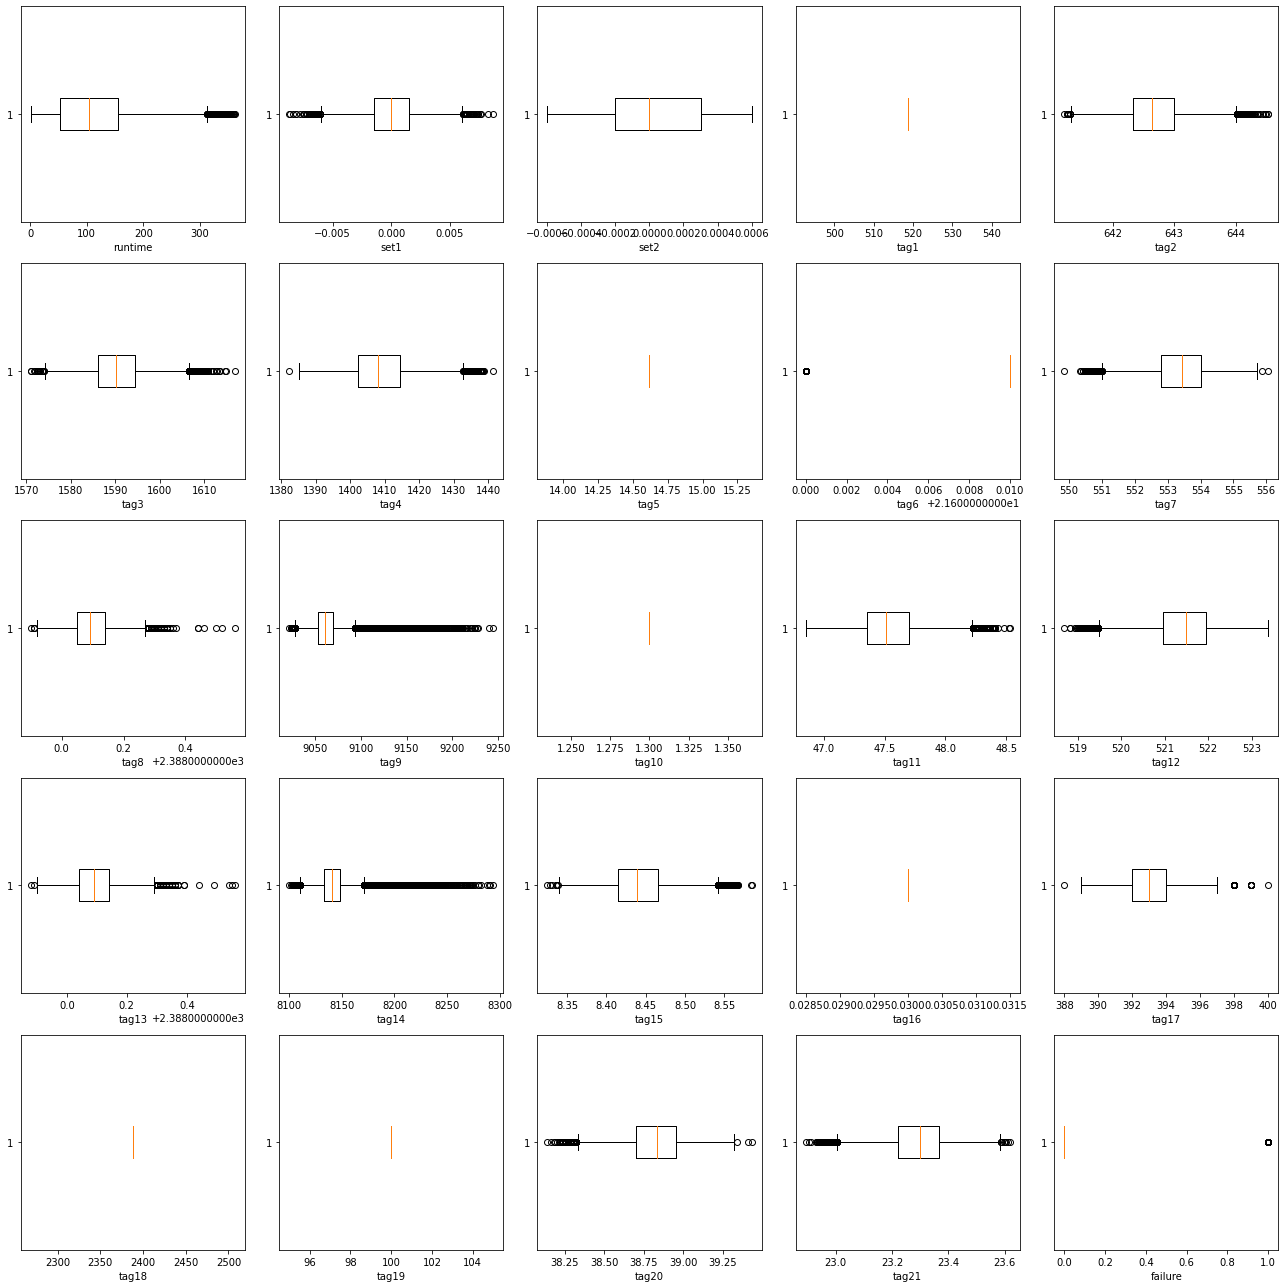

In [21]:
# verificar a existência de outliers

# iterar por todas as colunas e construir boxplots
fig = plt.figure(figsize=(18, 18))
for i in range(1, 26):
    
    ax = fig.add_subplot(5, 5, i)
    ax.boxplot(data.iloc[:, i-1], vert=False)
    ax.set_xlabel(data.columns[i-1])

plt.tight_layout()
plt.show()

Nesse caso específico, a grande maioria dos dados apresenta candidatos a outliers, porém se pode verificar que há muitos pontos muito próximos desses potenciais outliers. Assim sendo, parecem mais *ruídos de medição* do que realmente outliers. **Escolhe-se não fazer nada a respeito, visto que essa é uma primeira versão de modelagem**.

In [22]:
# confirmando a "estranheza" da tag6
data.tag6.value_counts()

21.61    20225
21.60      406
Name: tag6, dtype: int64

In [23]:
# eliminar coluna tag6 devido a possuir uma variância quase nula
data.drop(['tag6'], axis=1, inplace=True)

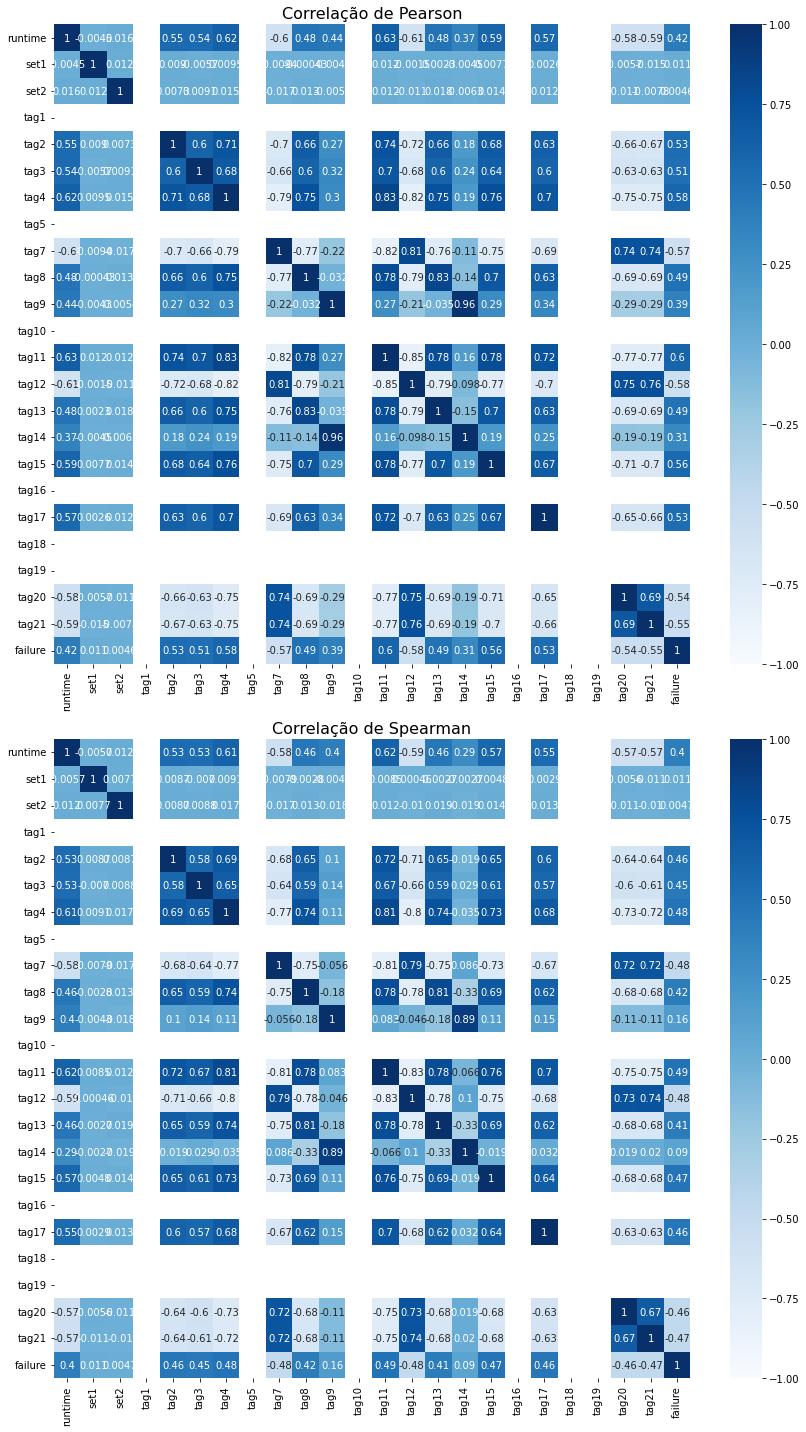

In [26]:
# análise de correlação (verificar multicolinearidade)
fig = plt.figure(figsize=(12, 20))

ax = fig.add_subplot(2, 1, 1)
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='Blues', ax=ax)
ax.set_title('Correlação de Pearson', size=16)

ax = fig.add_subplot(2, 1, 2)
sns.heatmap(data.corr(method='spearman'),
            annot=True, vmin=-1, vmax=1, center=0, cmap='Blues', ax=ax)
ax.set_title('Correlação de Spearman', size=16)

plt.tight_layout()
plt.show()

Interessante notar que temos muitos efeitos de correlação cruzada entre as features. Algumas correlações não puderam ser calculadas devido à zero variâncias desses atributos. Para tratar desse problema, vamos usar dois caminhos no pipeline de modelagem:

1. Seleção de atributos com `SelectKBest` e `f_classif`, seguido de RFE com Lasso
2. Seleção de atributos com `SelectKBest` e `f_classif`, seguido de PCA

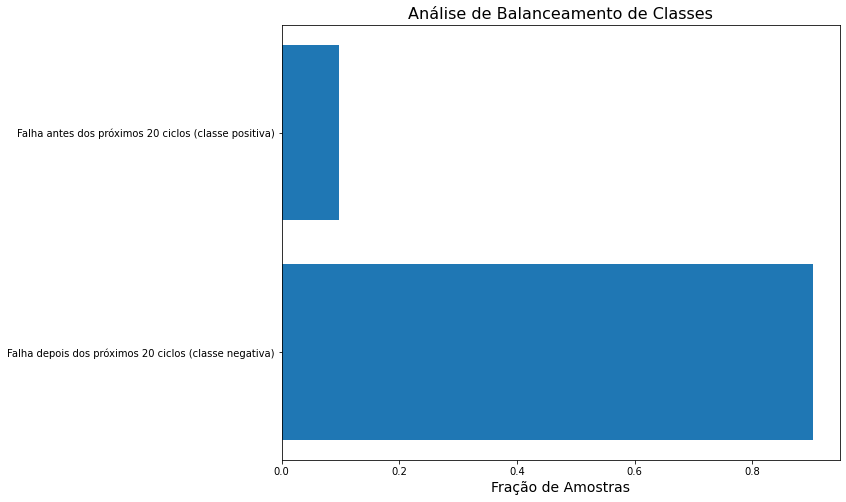

In [28]:
# análise do balanceamento de classes

# conta os exemplos de cada classe
class_count = data.failure.value_counts(normalize=True)

# gráfico para checar contagens
plt.figure(figsize=(10, 8))
plt.barh(y=class_count.index, width=class_count.values)
plt.xlabel('Fração de Amostras', size=14)
plt.title('Análise de Balanceamento de Classes', size=16)
plt.yticks(ticks=[0, 1], labels=['Falha depois dos próximos 20 ciclos (classe negativa)',
                                 'Falha antes dos próximos 20 ciclos (classe positiva)'])
plt.show()

Podemos ver que existe um forte desbalanceamento de classes nesse dataset. Nesse caso, teremos de testar algoritmos de reamostragem.

A reamostragem é uma técnica utilizada para reduzir o viés gerado no treinamento de bases de dados desbalanceadas. Se um modelo for treinado na base desbalanceada, ele corre o risco de ser tendencioso para predizer a classe majoritária. Nesse caso, podemos aplicar certas transformações no dataset para criar um balanceamento das classes. **Visto que é uma transformação que modifica as distribuições de probabilidades, ela deve ser aplicada apenas na base de treinamento**.

Existem basicamente três tipos de técnicas de reamostragem (mais detalhes podem ser vistos [aqui](https://towardsdatascience.com/machine-learning-resampling-techniques-for-class-imbalances-30cbe2415867))

- **Sub-amostragem** ou *undersampling* - onde registros da classe majoritária são eliminados até que as classes sejam balanceadas. Exemplos de algoritmos: *RandomUnderSampling*
- **Sobre-amostragem** ou *oversampling* - registros da classe minoritária são repetidos ou criados artificialmente até o balanceamento de classes ser alcançado. Exemplos de algoritmos: *RandomOverSampling*, *SMOTE*, *AdaptativeOverSampling*.
- **Técnicas híbridas** - aplicam as duas formas de reamostragem, concomitantemente.

Um pacote interessante que pode ajudar a aplicar técnicas de reamostragem é o `imblearn`, construído sobre a mesma interface do `scikit-learn`. [Esse](https://imbalanced-learn.org/stable/) é o link para a documentação.

### Seleção de Atributos baseada em Testes de Hipóteses

O cálculo de correlações não é a melhor abordagem para selecionar atributos para problemas de classificação, visto que o conceito de variância não se aplica para classes (da mesma forma que para números). Uma forma de investigar se um atributo é um bom separador para a classe é aplicando-se testes de hipóteses (essencialmente é o que o `SelectKBest` faz). Separando-se o dataset em duas classes e testando-se para a diferença de médias (apenas para features numéricas - para features categóricas teria de ser o $\chi^2$) é possível determinar se o feature separa bem a classe alvo.

Os testes aplicados serão os seguintes:

- **Mann-Whitney U Test:** um teste não paramétrico, baseado na comparação de rankings de amostras. Não leva em consideração as distribuições dos features nos subgrupos.
- **Student's t Test for Independent samples:** um teste paramétrico e estatísticamente mais robusto, porém que assume que as amostras são normalmente distribuídas. Aqui, vamos assumir válido o Teorema do Limite Central devido ao tamanho amostral. 

Hipóteses testadas para o Mann-Whitney:

- $H_0$: os rankings de ordenação são semelhantes para os dois subgrupos e portanto, as amostras vieram da mesma distribuição.
- $H_1$: os rankings de ordenação são diferentes para os subgrupos e portanto, eles foram amostrados de distribuições diferentes.

Hipóteses testadas para o t de Student:

- $H_0$: as médias amostrais dos dois subgrupos são semelhantes.
- $H_1$: as médias amostrais dos dois subgrupos são diferentes

Em ambos os casos, vamos usar um nível mímino de significância de $\alpha=0.05$

In [31]:
# iterando pelas colunas para aplicar os testes
# de hipóteses e calcular o p-valor
mwu = []
ttest_het = []
ttest_homo = []
for col in data.columns:

    # não testar o target consigo mesmo
    if col not in ['failure']:

        # separa os grupos
        group0 = data.loc[data.failure==0, col].values
        group1 = data.loc[data.failure==1, col].values

        # Mann Whitney
        _, p = mannwhitneyu(group0, group1)
        mwu.append(p)

        # t de Student - caso homocedástico
        _, p = ttest_ind(group0, group1, equal_var=True)
        ttest_homo.append(p)

        # t de Student - caso heterocedástico
        _, p = ttest_ind(group0, group1, equal_var=False)
        ttest_het.append(p)

# resumo das estatísticas
summary_data = pd.DataFrame(
    list([col for col in data.columns if col != 'failure']),
    columns=['feature']
)
summary_data['mwu'] = mwu
summary_data['student_homo'] = ttest_homo
summary_data['student_het'] = ttest_het

In [33]:
# apresentação dos resultados
summary_data.set_index('feature', drop=True)

,mwu,student_homo,student_het
feature,,,
runtime,0.000000e+00,0.000000e+00,0.000000e+00
set1,1.272887e-01,1.241257e-01,1.299168e-01
set2,4.971225e-01,5.052437e-01,4.999756e-01
tag1,1.000000e+00,NaN,NaN
tag2,0.000000e+00,0.000000e+00,0.000000e+00
tag3,0.000000e+00,0.000000e+00,0.000000e+00
tag4,0.000000e+00,0.000000e+00,0.000000e+00
tag5,1.000000e+00,2.508434e-296,3.291008e-97
tag7,0.000000e+00,0.000000e+00,0.000000e+00


<Figure size 1296x1296 with 0 Axes>

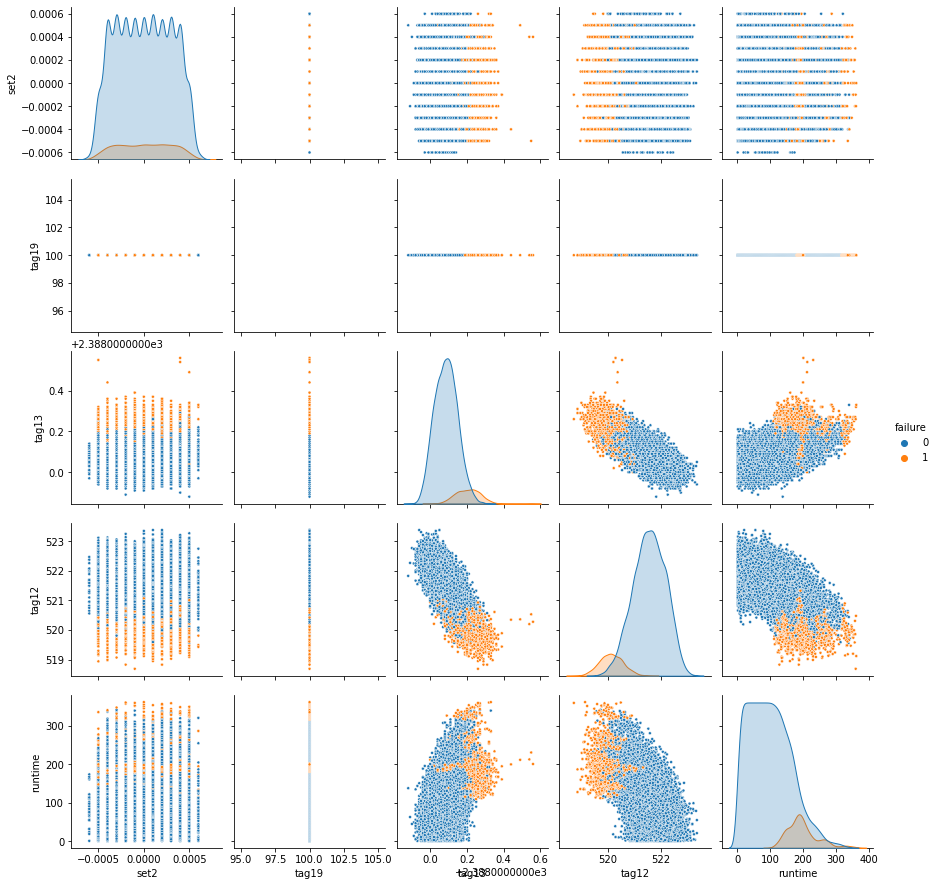

In [37]:
# verificar a separabilidade linear
# escolher aleatoriamente 5 features para amostrar
sep_cols = list(np.random.choice(summary_data['feature'].values, size=5))

# preciso da coluna failure na lista
sep_cols.append('failure')

# pairplot para verificar separabilidade linear
plt.figure(figsize=(18, 18))
sns.pairplot(data[sep_cols], hue='failure', markers='.', palette='tab10')
plt.show()

### **3. Modelagem**

Conforme verificado, nosso Pipeline tem as seguintes tarefas:

1. Eliminar features com variância zero
2. Selecionar features que possuam boa participação na separação
2. Transformar para distribuição normal
3. Escalonar
4. Balancear classes
5. Selecionar usando Lasso e RFE ou aplicar PCA
6. Modelar

In [40]:
# separar preditores e preditos
x = data.drop(['failure'], axis=1)
y = data[['failure']]

In [41]:
# separação do treino e teste
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

In [48]:
# função para avaliar métricas e desempenho
def evaluate(estimator: object,
             x: pd.DataFrame,
             y: pd.DataFrame) -> float:
    """
    função para avaliar o desempenho do modelo

    parâmtros:
        estimator: modelo treinado
        x: features
        y: targets
    retorna:
        f1_score da base
    """

    # realizar predições
    yhat = estimator.predict(x)

    # imprimir matriz de confusão
    ConfusionMatrixDisplay.from_predictions(y_true=y, y_pred=yhat)

    # retornar o score f1
    return f1_score(y, yhat)

#### **3.1. Modelo Baseline**

Nossas modificações para a modelagem devem ter efeito em relação a uma referência. Nossa referência será um modelo simples de Regressão Logística sem regularização.

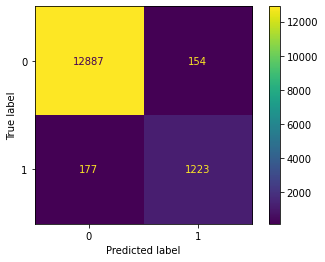

In [49]:
# criando o modelo baseline
base = Pipeline([
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(penalty='none'))
])

# ajusta o modelo
base.fit(x_train, y_train)

# avaliando a métrica na base de treinamento
f1_train = evaluate(base, x_train, y_train)

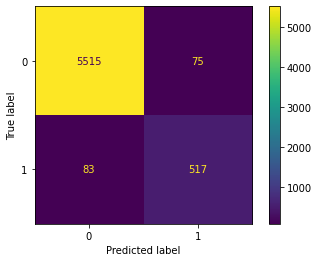

In [50]:
# avaliando na base de teste
f1_test = evaluate(base, x_test, y_test)

In [56]:
# criar um "monitor de modelos"
score_df = pd.DataFrame(columns=['f1_train', 'f1_test', 'pipeline_name'])
score_df.loc['Baseline', ['f1_train', 'f1_test', 'pipeline_name']] = f1_train, f1_test, 'base'
score_df

,f1_train,f1_test,pipeline_name
Baseline,0.880807,0.86745,base


#### **3.2. Modelo com Feature Selection (Filter) e QuantileTransformer**

In [54]:
# criar um transformador de colunas (quantile transformer)
quant_cols = [col for col in x.columns if col != 'runtime']

# configurar o pipeline transformador
quant_pipe = Pipeline([('quantile_transformer', QuantileTransformer())])

# configurar o transformador de colunas
quant_transf = ColumnTransformer(
    [('quantiles_cols',
    quant_pipe,
    quant_cols)],
    remainder='passthrough'
)

In [58]:
# configurar o pipeline de modelagem
model_pipe1 = Pipeline([
    ('filter_variance', VarianceThreshold()),
    ('filter_f_classif', SelectKBest(f_classif)),
    ('col_transformer', quant_transf),
    ('scaler', RobustScaler()),
    ('model', LogisticRegression(solver='saga', random_state=RANDOM_SEED))
])

# dicionário de parâmetros
params = {
    'filter_f_classif__k': range(2, 16),
    'model__C': np.random.uniform(0.001, 1, 1000),
    'model__penalty': ['l1', 'l2']
}

# configurar nosso separador de folds
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

# configuro o objeto de busca
search = RandomizedSearchCV(
    estimator=model_pipe1,
    param_distributions=params,
    n_iter=100,
    cv=cvs,
    random_state=RANDOM_SEED,
    refit=True,
    scoring='f1'
)

# ajuste
search.fit(x_train, y_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames